# Water Quality Index (WQI) Analysis

In this notebook, we perform an **Exploratory Data Analysis (EDA)** based on the **raw dataset** referenced in the following study:  
[A simple dataset of water quality on aquaponic fish ponds based on an internet of things measurement device](https://doi.org/10.1016/j.dib.2023.109248).

Although the authors of the study provide a version they refer to as **"filtered" data**, we intentionally work with the **raw, unfiltered measurements**. This choice reflects a more realistic and challenging data scenario, closer to what would be encountered in live aquaculture environments using IoT sensors.

To avoid ambiguity, we adopt the following terminology in this notebook:

- **Raw data**: Original measurements directly obtained from the IoT devices, without any filtering or transformation.
- **Clean data**: Data that has been preprocessed to remove invalid entries, outliers, or clearly erroneous values, but **not yet smoothed or filtered**.
- **Filtered data**: Data that has undergone computational signal processing, such as smoothing, moving averages, or low-pass filtering techniques.

This distinction is essential for clarity in subsequent stages, particularly when applying signal processing or statistical modeling techniques.


---

## Dataset Description

The dataset contains water quality measurements from an **aquaponic fish pond** monitored with IoT sensors over approximately three months (January to March 2023). Each record includes:

| Column Name         | Description                                         | Units         |
|---------------------|-----------------------------------------------------|---------------|
| `id`                | Unique identifier for each measurement              | —             |
| `created_date`     | Timestamp when measurement was recorded             | DateTime      |
| `pH value`         | Water pH measured in real-time                      | pH units      |
| `TDS`              | Total Dissolved Solids concentration                | mg/L (ppm)    |
| `water temperature`| Water temperature                                   | °C (Celsius)  |

### Relevance in Aquaculture Water Quality Monitoring:

- **pH value**: Critical for maintaining physiological homeostasis in aquatic animals. Suboptimal pH affects shrimp growth, molting, and survival.  
- **TDS**: Indicates the concentration of dissolved salts, minerals, and organic matter. Excessive TDS can cause osmotic stress.  
- **Water temperature**: Directly influences shrimp metabolism, immune response, and oxygen availability. Critical for optimizing feed conversion and survival rates.  

These variables are among the primary environmental parameters to be continuously monitored in shrimp aquaculture ponds to ensure animal health and water stability.

---
The raw dataset was **preprocessed** to ensure consistency and usability for modeling. This included:
- **Filling missing (NaN) values** using appropriate interpolation strategies  
- **Aggregating the data** to obtain average values over defined time intervals of 1-minute resolution
- **Smoothing the time series** to reduce short-term fluctuations and noise  

From this preprocessed dataset, the following variables were retained and used to compute the Water Quality Index (WQI), as detailed below, which includes:  
- **pH**  
- **Total Dissolved Solids (TDS)**  
- **Water Temperature**

--- 

### ✅ **Final WQI Equation (Adapted for Your Variables)**

$$
WQI = \frac{w_{\text{pH}} \times q_{\text{pH}} + w_{\text{TDS}} \times q_{\text{TDS}} + w_{\text{Temp}} \times q_{\text{Temp}}}{w_{\text{pH}} + w_{\text{TDS}} + w_{\text{Temp}}}
$$

where:  
- **$q_i$** are the sub-index quality ratings (scaled between 0–100)  
- **$w_i$** are the weights assigned to each variable  

---

### ✅ **Step 1: Compute Quality Ratings $q_i$**

We map each variable to a **quality rating between 0 and 100**, based on **ideal and permissible values**.

#### **1. pH Quality Rating**

$$
q_{\text{pH}} = \left( \frac{V_{\text{pH}} - 7}{8.5 - 7} \right) \times 100
$$

- $V_{\text{pH}}$ = observed pH value  
- **Ideal pH** = 7.0 (neutral)  
- **Standard max** = 8.5  

#### **2. TDS Quality Rating (Inverse Scale)**

$$
q_{\text{TDS}} = \left( 1 - \frac{V_{\text{TDS}}}{500} \right) \times 100
$$

- $V_{\text{TDS}}$ = observed TDS value  
- **Ideal TDS** = 0 mg/L  
- **Standard max** = 500 mg/L  
- **Higher TDS = Worse Quality** → **Inverted Scale**

#### **3. Temperature Quality Rating**

$$
q_{\text{Temp}} = \left( 1 - \frac{|V_{\text{Temp}} - 26|}{3} \right) \times 100
$$

- $V_{\text{Temp}}$ = observed water temperature  
- **Ideal Temp** = 26°C (optimal for shrimp)  
- **Acceptable range** = **24–27°C**  
- **Penalty** applied for deviation from **26°C**

---

### ✅ **Step 2: Compute Weights $w_i$**

Each variable gets a weight **inversely proportional to its maximum permissible value**:

$$
w_i = \frac{k}{S_i}
$$

Where $S_i$ is the **standard limit**, and $k$ is a proportionality constant.

Using:  
- $S_{\text{pH}} = 8.5$  
- $S_{\text{TDS}} = 500$  
- $S_{\text{Temp}} = 3$ (deviation range from 24°C - 27°C)  

Setting $k = 1$:

$$
w_{\text{pH}} = \frac{1}{8.5}, \quad w_{\text{TDS}} = \frac{1}{500}, \quad w_{\text{Temp}} = \frac{1}{3}
$$

---

### ✅ **Final WQI Computation**

$$
WQI = \frac{ \left( \frac{1}{8.5} \times q_{\text{pH}} \right) + \left( \frac{1}{500} \times q_{\text{TDS}} \right) + \left( \frac{1}{3} \times q_{\text{Temp}} \right) }{\frac{1}{8.5} + \frac{1}{500} + \frac{1}{3}}
$$

- **$WQI \approx 0 - 100$**  
- **Higher WQI = Better Water Quality**  
- **Lower WQI = Worse Water Quality**

---

## Visualizations

We will perform a time-based aggregation of the **loadeded data**  by computing **mean values within 1-minute temporal windows** to reduce noise and emphasize overall trends.

### Main visualization goals:

- Plot **aggregated pH, TDS, and temperature values** over time to gain insights into the dynamic behavior of water quality in the aquaponic system.
- Identify potential fluctuations or stable periods in water quality parameters relevant to shrimp aquaculture.

These visualizations will help us understand how the water quality evolves and prepare the dataset for further modeling (e.g., WQI estimation).

In [1]:
# === Path and system setup ===
from pathlib import Path
import sys

# === Step 1: Manually set project root ===
PROJECT_ROOT = Path().resolve().parents[0]

# === Step 2: Add project root to sys.path if not already present ===
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# === Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
from matplotlib import rc
from datetime import datetime, timedelta

# === Project imports ===
from scripts.plot_setup import configure_plots
from scripts.preprocessing import aggregate_df_by_time

# === Plotting configuration ===
_ = configure_plots()

## Load raw data

In the context of this project, we refer to the IoT dataset from the reference study as **raw data**, since it will undergo further processing steps. These include aggregation, missing value imputation, and smoothing, resulting in a preprocessed, filtered, and uniformly sampled dataset.

In [15]:
# Load data raw

path2file = PROJECT_ROOT / Path('data/raw')

filename_raw = 'pond_iot_2023_raw.csv'

df_raw = pd.read_csv(path2file/filename_raw)
df_raw = df_raw.drop(['id'], axis=1)

print(f'Shape of raw data:{df_raw.shape[0]} instances, {df_raw.shape[1]} columns.')

# flag was initialized 0 in a previus cell code
# Aggregate data by 1-minute intervals using mean. I used 
df_agg_min = aggregate_df_by_time(df_raw)

print(f'Shape of 1-min aggregated data:{df_agg_min.shape[0]} instances, {df_agg_min.shape[1]} columns.')
df_agg_min

Shape of raw data:505730 instances, 4 columns.
Shape of 1-min aggregated data:79636 instances, 4 columns.


,created_date,water_pH,TDS,water_temp
0,2023-01-26 10:38:00,7.8650,329.000000,23.69
1,2023-01-26 10:39:00,6.7825,233.000000,23.75
2,2023-01-26 10:40:00,7.3000,233.142857,23.75
3,2023-01-26 10:41:00,NaN,NaN,NaN
4,2023-01-26 10:42:00,NaN,NaN,NaN
...,...,...,...,...
79631,2023-03-22 17:49:00,NaN,NaN,NaN
79632,2023-03-22 17:50:00,NaN,NaN,NaN
79633,2023-03-22 17:51:00,NaN,NaN,NaN
79634,2023-03-22 17:52:00,8.4300,374.000000,26.06


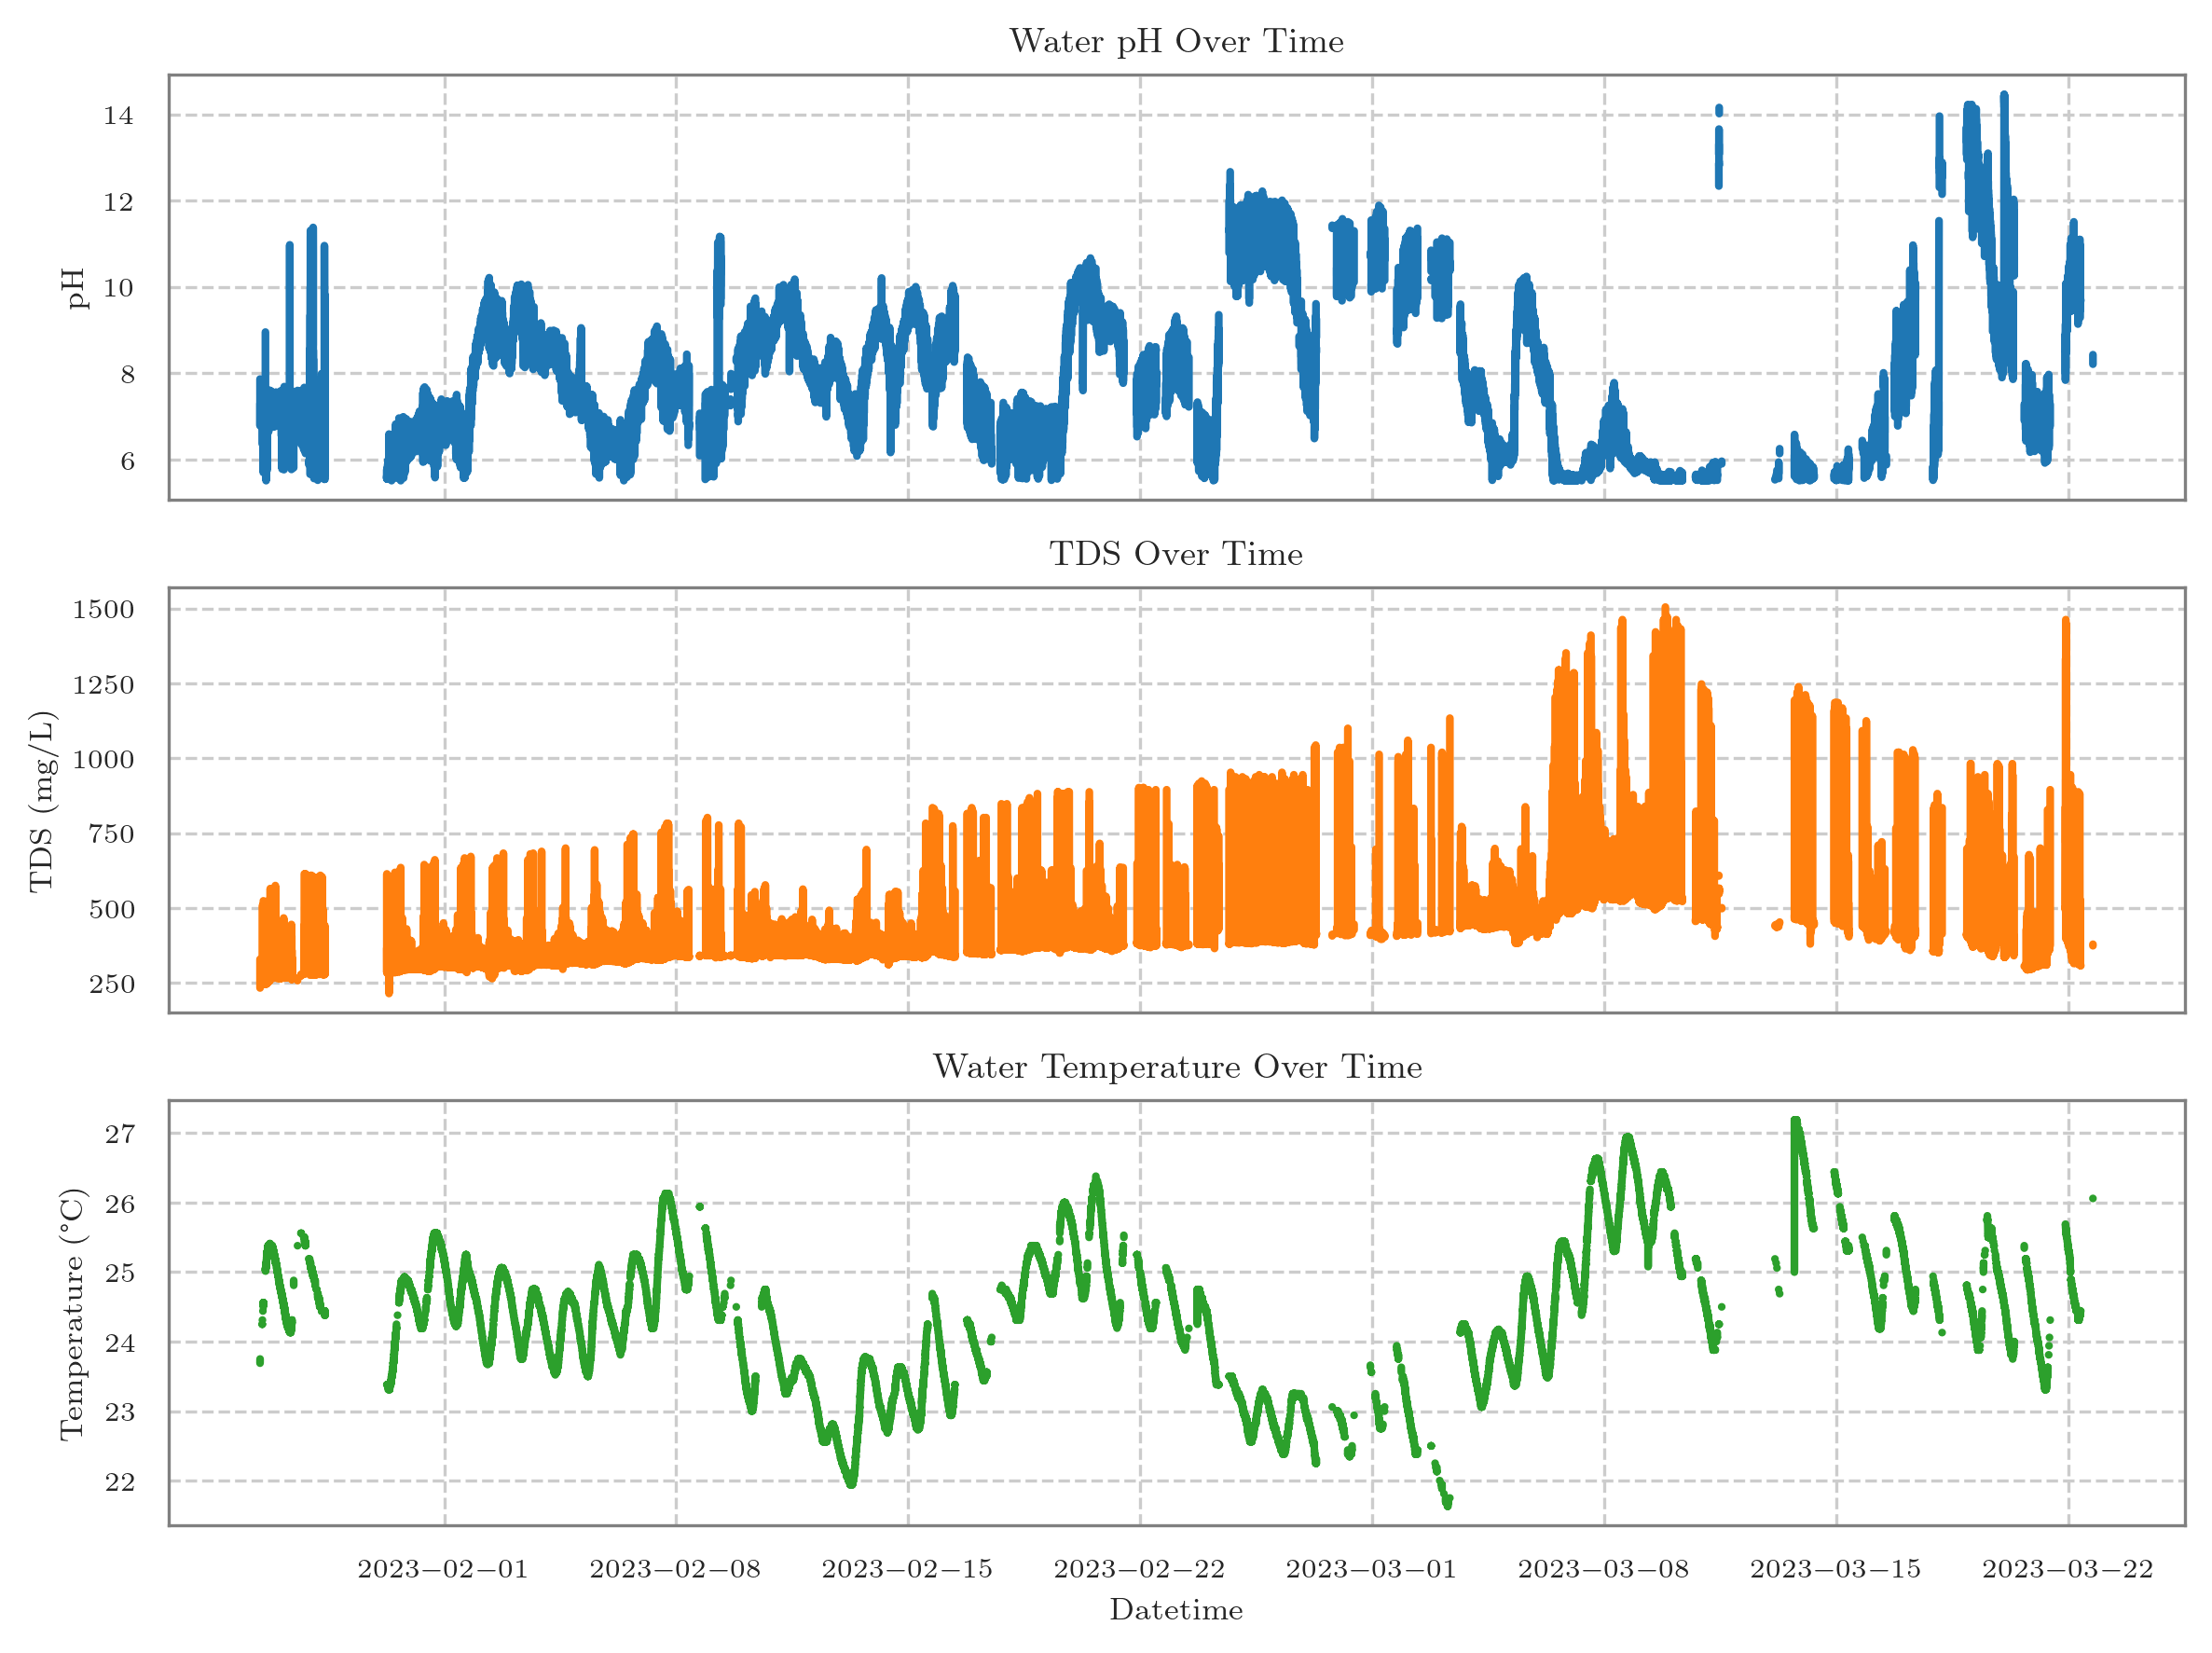

In [3]:
# Ensure 'created_date' is in datetime format (just in case)
df_agg_min['created_date'] = pd.to_datetime(df_agg_min['created_date'])

# Set up the figure with 3 subplots (stacked vertically)
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)  # sharex=True to share the datetime axis

# Plot each variable in a separate subplot
axs[0].plot(df_agg_min['created_date'], df_agg_min['water_pH'], color='tab:blue')
axs[0].set_ylabel('pH')
axs[0].set_title('Water pH Over Time')
axs[0].grid(True)

axs[1].plot(df_agg_min['created_date'], df_agg_min['TDS'], color='tab:orange')
axs[1].set_ylabel('TDS (mg/L)')
axs[1].set_title('TDS Over Time')
axs[1].grid(True)

axs[2].plot(df_agg_min['created_date'], df_agg_min['water_temp'], color='tab:green')
axs[2].set_ylabel('Temperature (°C)')
axs[2].set_title('Water Temperature Over Time')
axs[2].set_xlabel('Datetime')
axs[2].grid(True)

# fig.suptitle('Complete raw dataset')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

Detected date range: 2023-01-30 12:00:00 to 2023-02-08 12:00:00


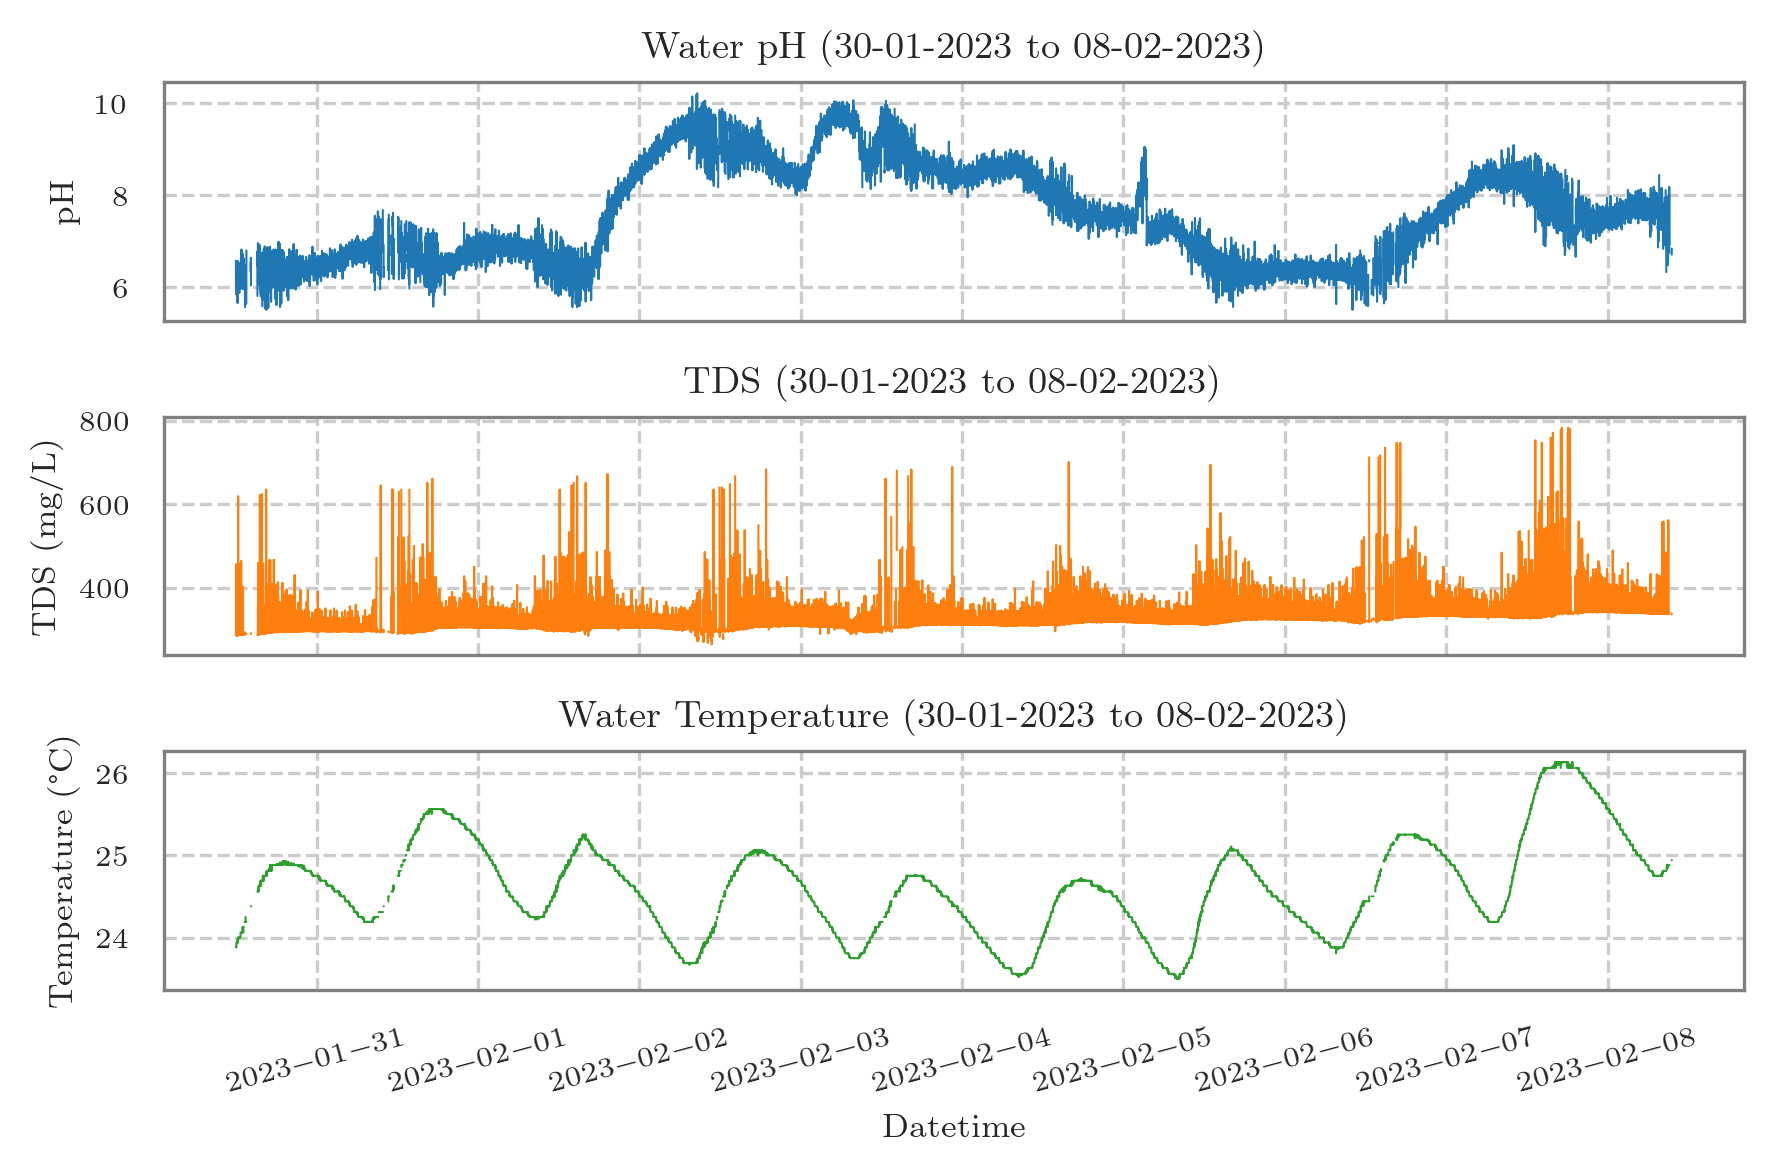

In [4]:
from scripts.preprocessing import select_time_slice_df

# Manually set start and end date for IoT data selection
start_date_str = '2023-01-30 12:00:00'
end_date_str = '2023-02-08 12:00:00'

# # Select IoT raw data between start and end automatically
# mask = (df_agg_min['created_date'] >= start_date_str) & (df_agg_min['created_date'] <= end_date_str)
# df_selected = df_agg_min.loc[mask].reset_index(drop=True)

df_selected = select_time_slice_df(df_agg_min, None, start_date_str, end_date_str)

# Automatically determine the min and max datetime in the dataset
start_date = df_selected['created_date'].min()
end_date = df_selected['created_date'].max()

# Optionally print to verify
print(f"Detected date range: {start_date} to {end_date}")

# Format for plot titles
start_str = start_date.strftime("%d-%m-%Y")
end_str = end_date.strftime("%d-%m-%Y")

# Set up the figure with 3 subplots (stacked vertically)
fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True)

# Plot each variable in a separate subplot
axs[0].plot(df_selected['created_date'], df_selected['water_pH'], color='tab:blue', linewidth=0.5)
axs[0].set_ylabel('pH')
axs[0].set_title(f'Water pH ({start_str} to {end_str})')
axs[0].grid(True)

axs[1].plot(df_selected['created_date'], df_selected['TDS'], color='tab:orange', linewidth=0.5)
axs[1].set_ylabel('TDS (mg/L)')
axs[1].set_title(f'TDS ({start_str} to {end_str})')
axs[1].grid(True)

axs[2].plot(df_selected['created_date'], df_selected['water_temp'], color='tab:green', linewidth=0.5)
axs[2].set_ylabel('Temperature (°C)')
axs[2].set_title(f'Water Temperature ({start_str} to {end_str})')
axs[2].set_xlabel('Datetime')
axs[2].grid(True)
axs[2].tick_params(axis='x', rotation=15)

# Save to Results directory
results_fig_dir = PROJECT_ROOT/Path('results/figures')

# fig.suptitle('Complete raw dataset')

# Adjust layout to prevent overlap
plt.tight_layout()

fig_path = results_fig_dir / '01_Selected_Aggregated_Dataset.pdf'
fig.savefig(fig_path, format='pdf')

# Show plot
plt.show()

In [5]:
# ========== Smoothing selected data ================
from scripts.preprocessing import impute_missing_values, apply_single_pole_filter

# Define the columns to smooth and for missing value imputation (excluding 'created_date' and 'id')
cols = ['water_pH', 'TDS', 'water_temp']

# Apply polynomial interpolation (order=2)
df_imputed = impute_missing_values(df_selected, cols, order=1)

df_smoothed =  apply_single_pole_filter(df_imputed, cols, alpha=0.02)


# mask = (df_smoothed['created_date'] >= '2023-01-30 12:00:00') & (df_smoothed['created_date'] <= '2023-02-08 12:00:00')
df_smoothed = df_smoothed.reset_index(drop=True)
df_selected

,created_date,water_pH,TDS,water_temp
0,2023-01-30 12:00:00,6.448000,287.600000,23.88
1,2023-01-30 12:01:00,6.266667,288.333333,23.88
2,2023-01-30 12:02:00,6.575000,288.000000,23.88
3,2023-01-30 12:03:00,6.355000,456.000000,23.88
4,2023-01-30 12:04:00,6.180000,288.000000,23.88
...,...,...,...,...
12956,2023-02-08 11:56:00,NaN,NaN,NaN
12957,2023-02-08 11:57:00,NaN,NaN,NaN
12958,2023-02-08 11:58:00,NaN,NaN,NaN
12959,2023-02-08 11:59:00,NaN,NaN,NaN


In [6]:
import matplotlib.dates as mdates

def plot_rectangle(df, ax):
    from matplotlib.patches import Rectangle
    import matplotlib.dates as mdates

    # Define x and y limits for the rectangle
    x_start = df['created_date'].iloc[0]
    x_end   = df['created_date'].iloc[-1]
    y_min   = df['water_pH'].min()
    y_max   = df['water_pH'].max()

    # Convert datetime to matplotlib float representation
    x_start_num = mdates.date2num(x_start)
    x_end_num   = mdates.date2num(x_end)

    # Compute width and height
    rect_width  = x_end_num - x_start_num
    rect_height = y_max - y_min

    # Create and add rectangle
    rect = Rectangle(
        (x_start_num, y_min),       # (x, y) bottom-left corner
        rect_width, rect_height,    # width, height
        facecolor='#f0f0f0',
        edgecolor=None,
        zorder=0
    )

    ax.add_patch(rect)

    # Ensure datetime formatting is preserved
    ax.xaxis_date()


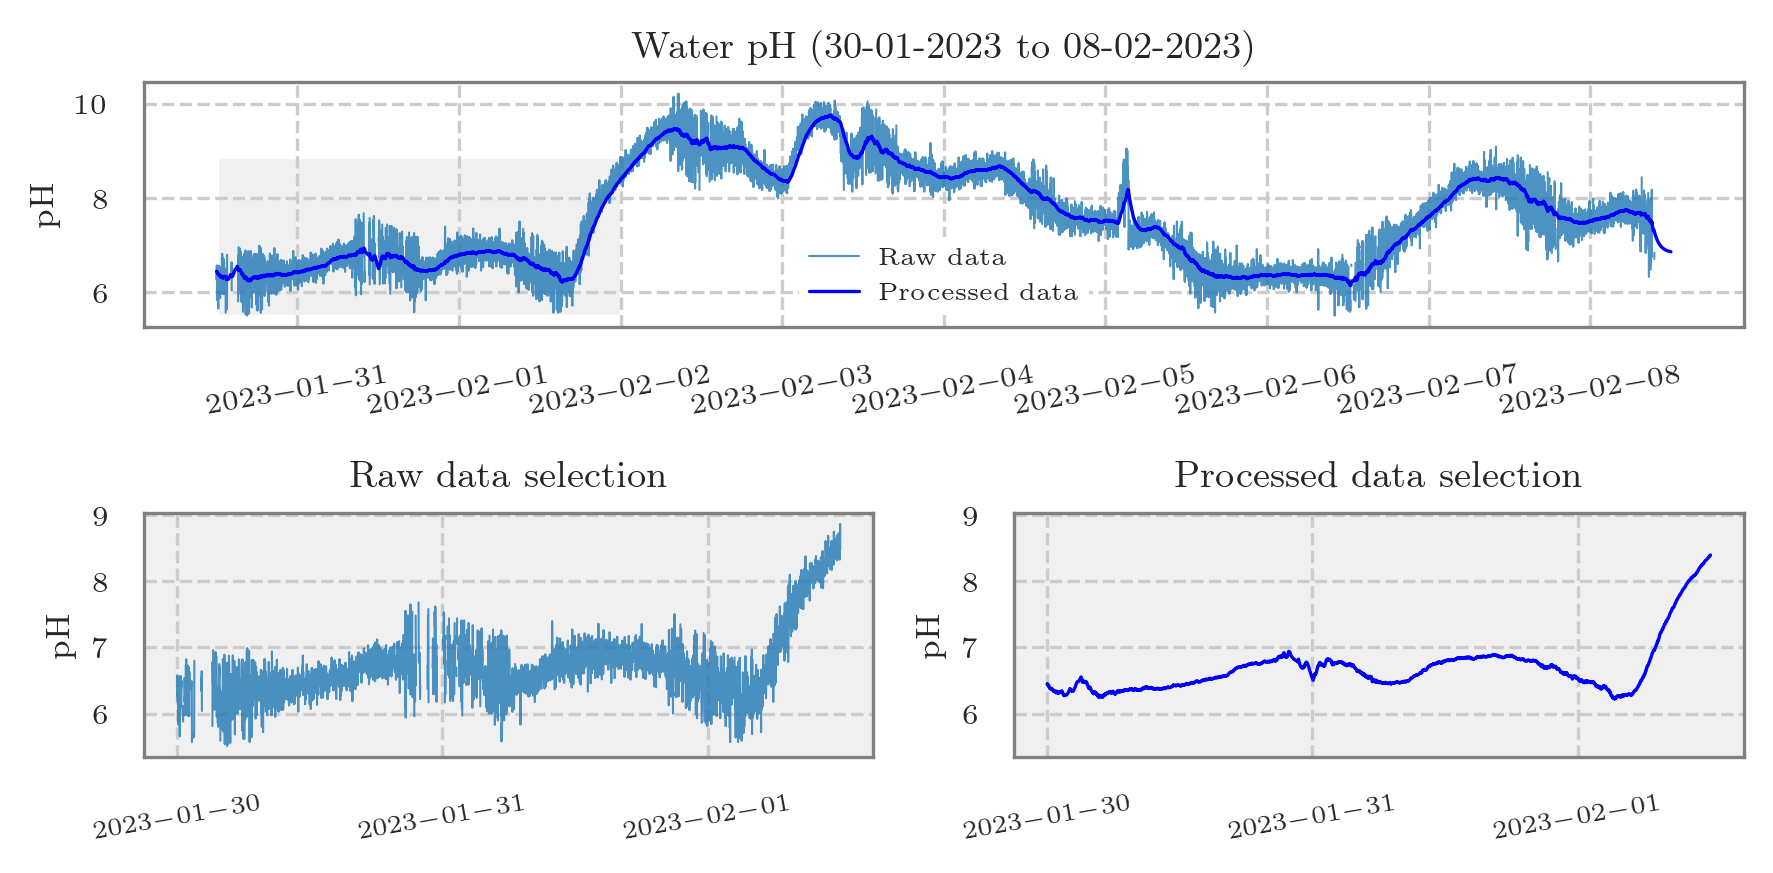

In [7]:
# Plot comparisom between raw and processed variavles

# Manually set start and end date for IoT data selection
start_date_str = '2023-01-30 12:00:00'
end_date_str = '2023-02-02 00:00:00'
df_raw_sel = select_time_slice_df(df_selected, None, start_date_str, end_date_str)
df_processed_sel = select_time_slice_df(df_smoothed, None, start_date_str, end_date_str)

# Set up the figure with 3 subplots (stacked vertically)
fig = plt.figure(figsize=(6, 3))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1, sharey=ax2)

axs = [ax1, ax2, ax3]

plot_rectangle(df_raw_sel, ax1)

# Plot each variable in a separate subplot
axs[0].plot(df_selected['created_date'], df_selected['water_pH'], color='tab:blue', alpha = 0.8, linewidth=0.5, label = 'Raw data')
axs[0].plot(df_selected['created_date'], df_smoothed['water_pH'], color='blue', linewidth=0.8, label ='Processed data')
axs[0].set_ylabel('pH')
axs[0].set_title(f'Water pH ({start_str} to {end_str})')
axs[0].grid(True)
axs[0].tick_params(axis='x', rotation=10)
axs[0].legend(loc = 'lower center', edgecolor='none')

axs[1].plot(df_raw_sel['created_date'], df_raw_sel['water_pH'], color='tab:blue', alpha = 0.8, linewidth=0.5, label = 'Raw data')
axs[1].set_ylabel('pH')
axs[1].set_title(f'Raw data selection')
# axs[1].grid(False)
axs[1].tick_params(axis='x', rotation=10, labelsize= 6 )
axs[1].set_facecolor('#f0f0f0')  # or any hex/RGB color code
axs[1].set_xticks(df_raw_sel['created_date'][::1440])

axs[2].plot(df_processed_sel['created_date'], df_processed_sel['water_pH'], color='blue', linewidth=0.8, label ='Processed data')
axs[2].set_ylabel('pH')
axs[2].set_title(f'Processed data selection')
# axs[1].grid(False)
axs[2].tick_params(axis='x', rotation=10, labelsize= 6 )
axs[2].set_facecolor('#f0f0f0')  # or any hex/RGB color code
axs[2].set_xticks(df_raw_sel['created_date'][::1440])


# Adjust layout to prevent overlap
plt.tight_layout()

fig_path = results_fig_dir / '02_Sample_Processed_pH.pdf'
fig.savefig(fig_path, format='pdf', dpi = 600)

# Show plot
plt.show()


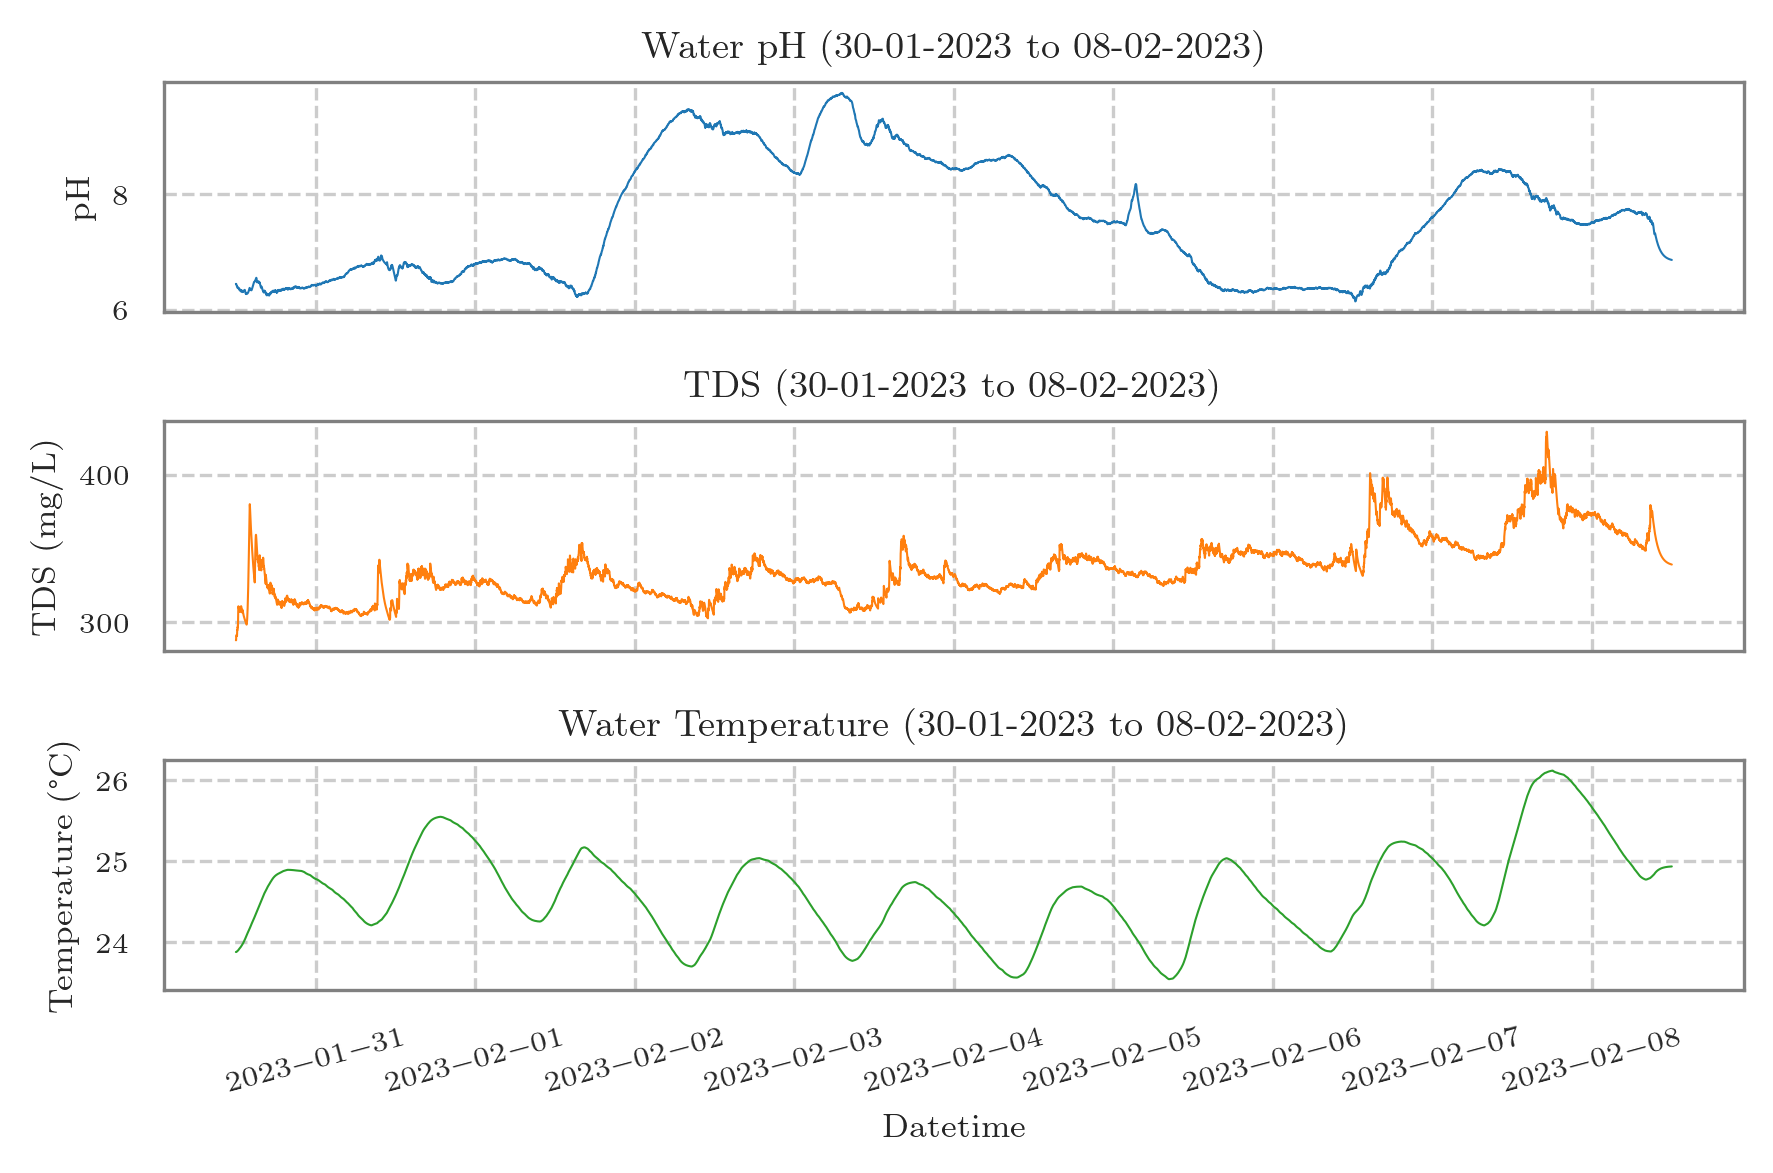

In [8]:
# Plot the smoothed data

# Set up the figure with 3 subplots (stacked vertically)
fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True)

# Plot each variable in a separate subplot
axs[0].plot(df_selected['created_date'], df_smoothed['water_pH'], color='tab:blue', linewidth=0.5)
axs[0].set_ylabel('pH')
axs[0].set_title(f'Water pH ({start_str} to {end_str})')
axs[0].grid(True)

axs[1].plot(df_selected['created_date'], df_smoothed['TDS'], color='tab:orange', linewidth=0.5)
axs[1].set_ylabel('TDS (mg/L)')
axs[1].set_title(f'TDS ({start_str} to {end_str})')
axs[1].grid(True)

axs[2].plot(df_selected['created_date'], df_smoothed['water_temp'], color='tab:green', linewidth=0.5)
axs[2].set_ylabel('Temperature (°C)')
axs[2].set_title(f'Water Temperature ({start_str} to {end_str})')
axs[2].set_xlabel('Datetime')
axs[2].grid(True)
axs[2].tick_params(axis='x', rotation=15)

# Save to Results directory
results_fig_dir = PROJECT_ROOT/Path('results/figures')

# fig.suptitle('Complete raw dataset')

# Adjust layout to prevent overlap
plt.tight_layout()

fig_path = results_fig_dir / '03_Selected_Smoothed_Dataset.pdf'
fig.savefig(fig_path, format='pdf')

# Show plot
plt.show()

In [9]:
# Get the number of samples and duration in days:hours:min

# Start and end datetime values from the dataset
start_date = df_smoothed['created_date'].iloc[0]
end_date = df_smoothed['created_date'].iloc[-1]

# Time difference as a timedelta object
difference = end_date - start_date

# Access days directly
days = difference.days

# The remaining time after whole days
hours = difference.seconds // 3600
minutes = (difference.seconds % 3600) // 60

# Print results
print(f"Total duration of the selected dataset: {days} days, {hours} hours, {minutes} minutes")
print(f"Number of samples in the selected dataset: {len(df_smoothed)} samples\n")

# ✅ Expectation for 1-minute intervals
# At 1-minute intervals, the number of samples should be samples=(total minutes)+1

Total duration of the selected dataset: 9 days, 0 hours, 0 minutes
Number of samples in the selected dataset: 12961 samples



In [10]:
# Compute WQI
from scripts.preprocessing import compute_wqi_from_values, compute_wqm_from_values, compute_wqiRMS_from_values

water_pH, TDS, water_temp = df_smoothed['water_pH'].values, df_smoothed['TDS'].values, df_smoothed['water_temp'].values

WQI = compute_wqi_from_values(water_pH, TDS, water_temp)
WQM = compute_wqm_from_values(water_pH, TDS, water_temp)
RMS_WQI = compute_wqiRMS_from_values(water_pH, TDS, water_temp)
# Add to WQI to the dataframe 
df_smoothed['WA_WQI'] = WQI
df_smoothed['WQM'] = WQM
df_smoothed['RMS_WQI'] = RMS_WQI

# Save the results to processed folder
filename = 'clean_filtered_pond_iot_2023.csv'
folder = 'data/processed'
path_processed = PROJECT_ROOT/Path(folder)/Path(filename)
df_smoothed.to_csv(path_processed)

## Add temporal cross-validation data

To evaluate the generalization ability of the prediction models over **unseen future data**, we performed a **cross-validation-style analysis** using a temporally **held-out test window**, distinct from the training interval.

The models were trained on the following time slice:

* **Training start date**: `'2023-01-30 12:00:00'`
* **Training end date**: `'2023-02-08 12:00:00'`

The temporal **cross-validation test window** is defined as:

* **Test start date**: `'2023-03-01 12:00:00'`
* **Test end date**: `'2023-03-08 12:00:00'`

Within this held-out segment, we constructed **five overlapping validation folds**, each consisting of a **3-day window with a 2-day overlap** between consecutive folds. This strategy allows us to test model robustness across slightly shifted but contiguous future intervals — preserving **temporal consistency** and ensuring that **no future data leaks into training**.

This approach helps characterize the **stability of model performance** across time, which is critical in dynamic environments like environmental or IoT-based monitoring systems.

---

#### ⬇️ Cross-validation folds used in the held-out March segment: 2-Day Folds with 8h Steps Starting from March 4

| Fold | Start Date & Time   | End Date & Time     | Duration |
| ---- | ------------------- | ------------------- | -------- |
| 1    | 2023-03-04 00:00:00 | 2023-03-05 23:59:00 | 2 days   |
| 2    | 2023-03-04 08:00:00 | 2023-03-06 07:59:00 | 2 days   |
| 3    | 2023-03-04 16:00:00 | 2023-03-06 15:59:00 | 2 days   |
| 4    | 2023-03-05 00:00:00 | 2023-03-06 23:59:00 | 2 days   |
| 5    | 2023-03-05 08:00:00 | 2023-03-07 07:59:00 | 2 days   |



Detected date range: 2023-03-04 00:00:00 to 2023-03-07 12:00:00


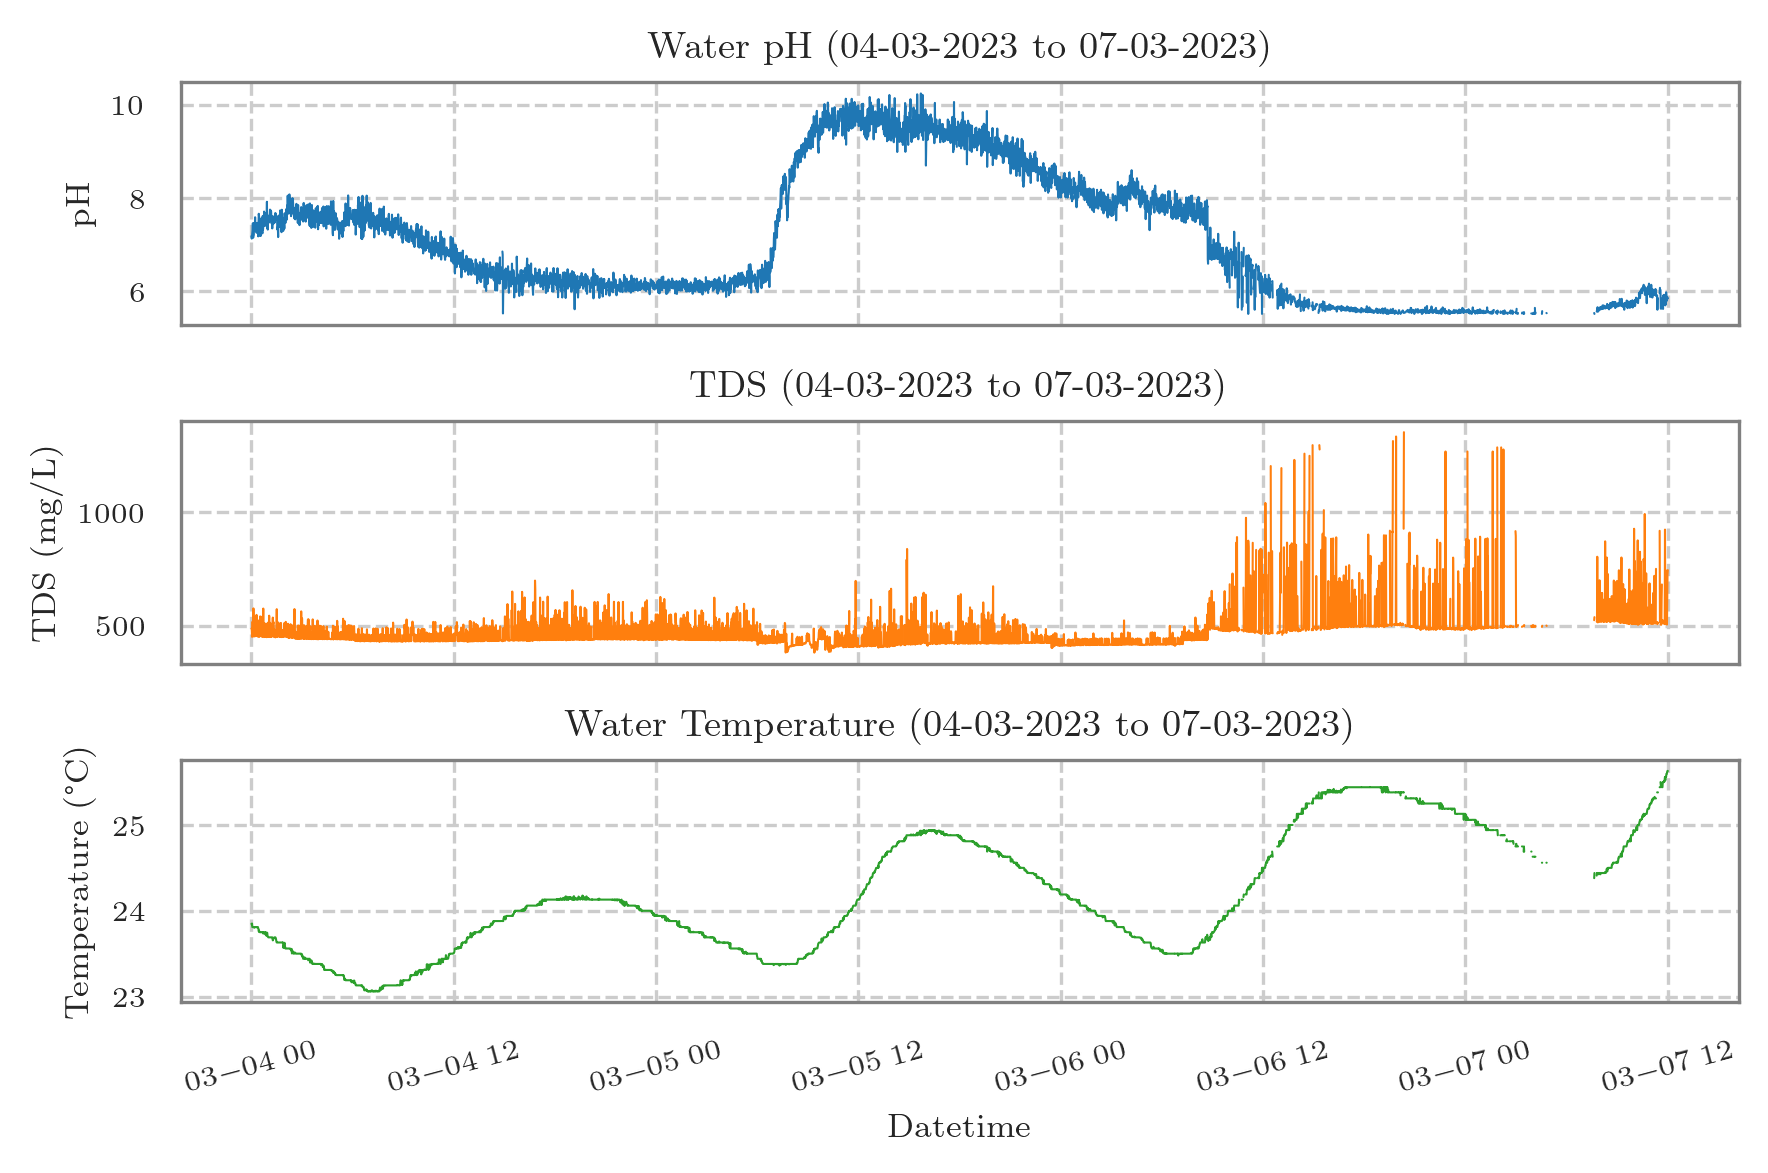

In [11]:
# Manually set start and end date for IoT data selection
start_date_str = '2023-03-04 00:00:00'
end_date_str = '2023-03-07 12:00:00'

df_selected = select_time_slice_df(df_agg_min, None, start_date_str, end_date_str)

# Automatically determine the min and max datetime in the dataset
start_date = df_selected['created_date'].min()
end_date = df_selected['created_date'].max()

# Optionally print to verify
print(f"Detected date range: {start_date} to {end_date}")

# Format for plot titles
start_str = start_date.strftime("%d-%m-%Y")
end_str = end_date.strftime("%d-%m-%Y")

# Set up the figure with 3 subplots (stacked vertically)
fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True)

# Plot each variable in a separate subplot
axs[0].plot(df_selected['created_date'], df_selected['water_pH'], color='tab:blue', linewidth=0.5)
axs[0].set_ylabel('pH')
axs[0].set_title(f'Water pH ({start_str} to {end_str})')
axs[0].grid(True)

axs[1].plot(df_selected['created_date'], df_selected['TDS'], color='tab:orange', linewidth=0.5)
axs[1].set_ylabel('TDS (mg/L)')
axs[1].set_title(f'TDS ({start_str} to {end_str})')
axs[1].grid(True)

axs[2].plot(df_selected['created_date'], df_selected['water_temp'], color='tab:green', linewidth=0.5)
axs[2].set_ylabel('Temperature (°C)')
axs[2].set_title(f'Water Temperature ({start_str} to {end_str})')
axs[2].set_xlabel('Datetime')
axs[2].grid(True)
axs[2].tick_params(axis='x', rotation=15)

# Save to Results directory
results_fig_dir = PROJECT_ROOT/Path('results/figures')

# fig.suptitle('Complete raw dataset')

# Adjust layout to prevent overlap
plt.tight_layout()

fig_path = results_fig_dir / '04_Selected_Aggregated_Dataset_CrossValidation.pdf'
fig.savefig(fig_path, format='pdf')

# Show plot
plt.show()

In [12]:
# ========== Smoothing selected data ================
from scripts.preprocessing import impute_missing_values, apply_single_pole_filter

# Define the columns to smooth and for missing value imputation (excluding 'created_date' and 'id')
cols = ['water_pH', 'TDS', 'water_temp']

# Apply polynomial interpolation (order=2)
df_imputed = impute_missing_values(df_selected, cols, order=1)

df_smoothed =  apply_single_pole_filter(df_imputed, cols, alpha=0.02)


# mask = (df_smoothed['created_date'] >= '2023-01-30 12:00:00') & (df_smoothed['created_date'] <= '2023-02-08 12:00:00')
df_smoothed = df_smoothed.reset_index(drop=True)

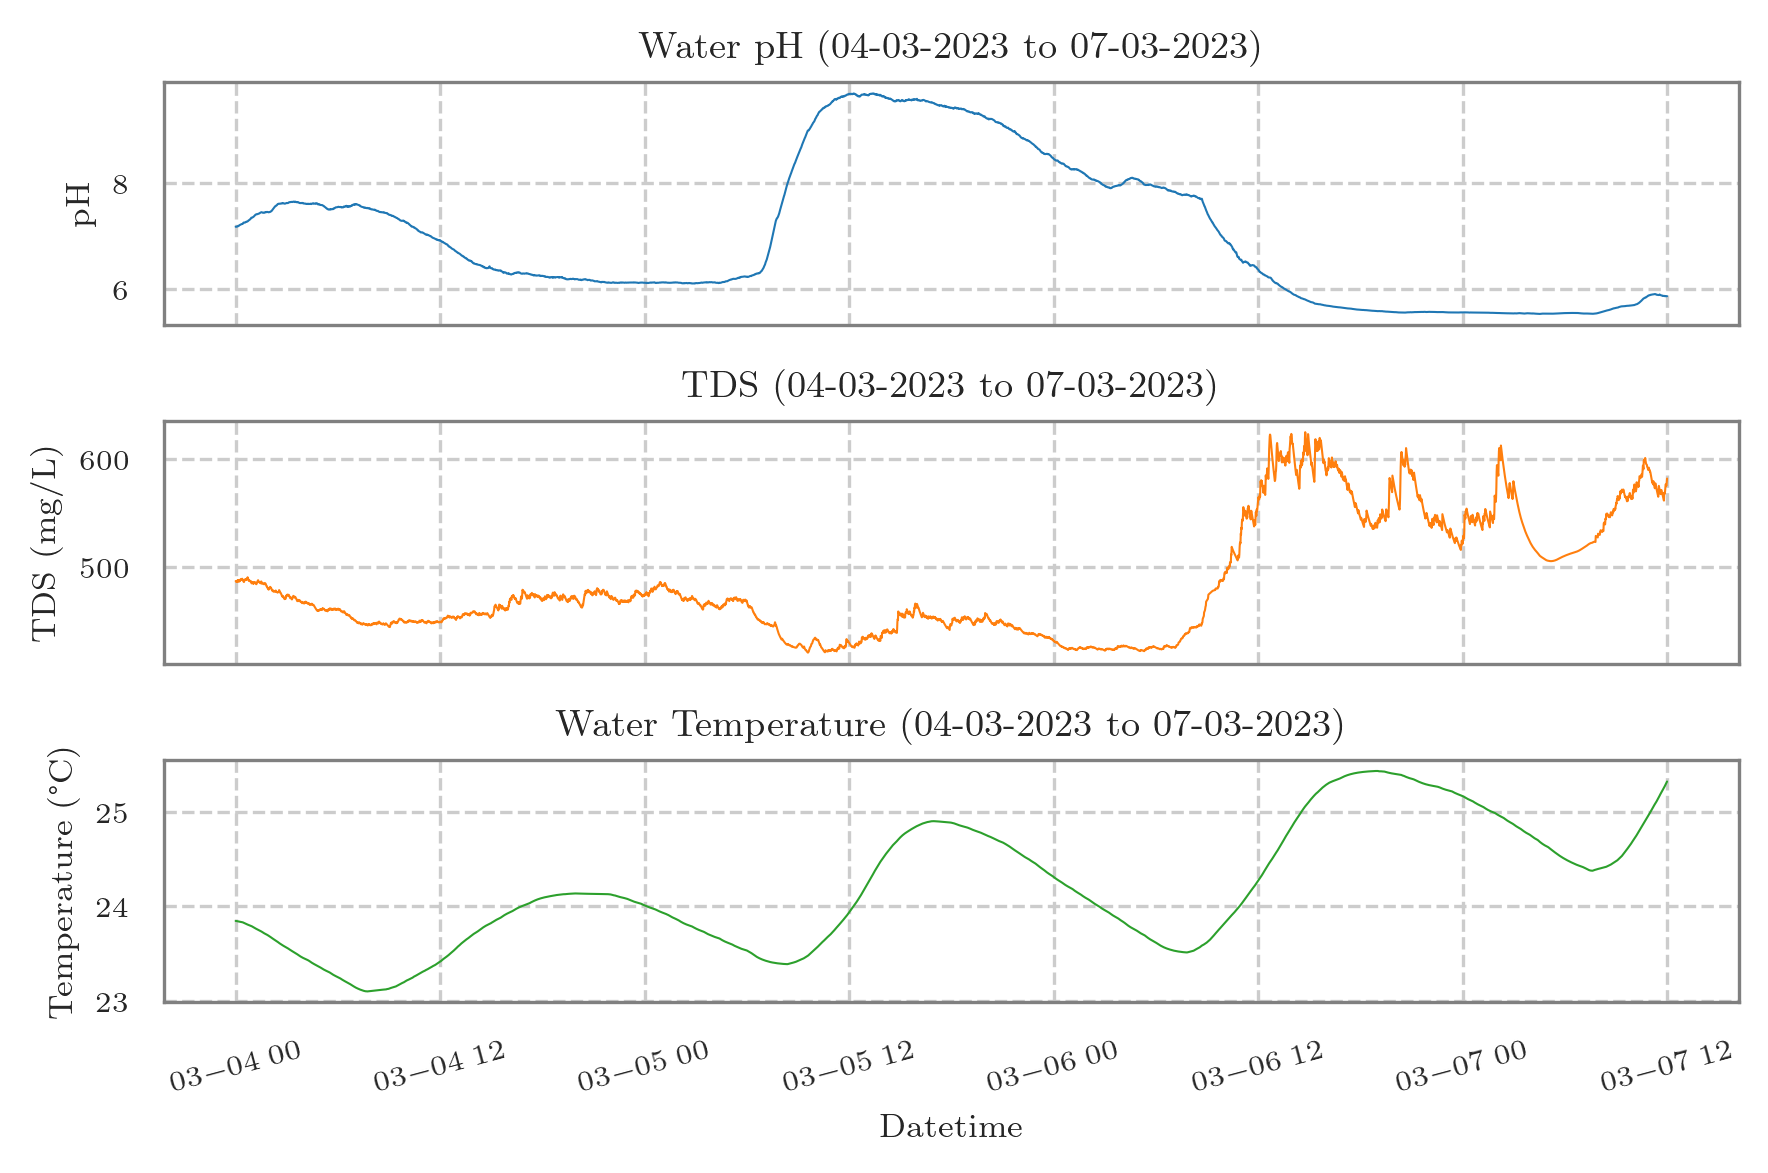

In [13]:
# Plot the smoothed data

# Set up the figure with 3 subplots (stacked vertically)
fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True)

# Plot each variable in a separate subplot
axs[0].plot(df_selected['created_date'], df_smoothed['water_pH'], color='tab:blue', linewidth=0.5)
axs[0].set_ylabel('pH')
axs[0].set_title(f'Water pH ({start_str} to {end_str})')
axs[0].grid(True)

axs[1].plot(df_selected['created_date'], df_smoothed['TDS'], color='tab:orange', linewidth=0.5)
axs[1].set_ylabel('TDS (mg/L)')
axs[1].set_title(f'TDS ({start_str} to {end_str})')
axs[1].grid(True)

axs[2].plot(df_selected['created_date'], df_smoothed['water_temp'], color='tab:green', linewidth=0.5)
axs[2].set_ylabel('Temperature (°C)')
axs[2].set_title(f'Water Temperature ({start_str} to {end_str})')
axs[2].set_xlabel('Datetime')
axs[2].grid(True)
axs[2].tick_params(axis='x', rotation=15)

# Save to Results directory
results_fig_dir = PROJECT_ROOT/Path('results/figures')

# fig.suptitle('Complete raw dataset')

# Adjust layout to prevent overlap
plt.tight_layout()

fig_path = results_fig_dir / '05_Selected_Smoothed_Dataset_CrossValidation.pdf'
fig.savefig(fig_path, format='pdf')

# Show plot
plt.show()

In [14]:
# Compute WQI
from scripts.preprocessing import compute_wqi_from_values, compute_wqm_from_values, compute_wqiRMS_from_values

water_pH, TDS, water_temp = df_smoothed['water_pH'].values, df_smoothed['TDS'].values, df_smoothed['water_temp'].values

WQI = compute_wqi_from_values(water_pH, TDS, water_temp)
WQM = compute_wqm_from_values(water_pH, TDS, water_temp)
RMS_WQI = compute_wqiRMS_from_values(water_pH, TDS, water_temp)
# Add to WQI to the dataframe 
df_smoothed['WA_WQI'] = WQI
df_smoothed['WQM'] = WQM
df_smoothed['RMS_WQI'] = RMS_WQI

# Save the results to processed folder
filename = 'clean_filtered_pond_iot_2023_crossvalidation.csv'
folder = 'data/processed'
path_processed = PROJECT_ROOT/Path(folder)/Path(filename)
df_smoothed.to_csv(path_processed)